# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [2]:
# script params
EXEC: bool = False

In [20]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
print("Compilation process:")
print("    + sequential_vector")
!g++ -o bin/tp_openmp_part_2_vector_sequential_vector tp_openmp_part_2_vector_sequential_vector.cpp -fopenmp -O3 -march=native -Wall

print("    + sequential_array")
!g++ -o bin/tp_openmp_part_2_vector_sequential_array tp_openmp_part_2_vector_sequential_array.cpp -fopenmp -O3 -march=native -Wall

print("    + omp_parallel_vector")
!g++ -o bin/tp_openmp_part_2_vector_omp_parallel_vector tp_openmp_part_2_vector_omp_parallel_vector.cpp -fopenmp -O3 -march=native -Wall

print("    + omp_parallel_array")
!g++ -o bin/tp_openmp_part_2_vector_omp_parallel_array tp_openmp_part_2_vector_omp_parallel_array.cpp -fopenmp -O3 -march=native -Wall

print("    + omp SIMD parallel array")
!g++ -o bin/tp_openmp_part_2_vector_omp_simd_parallel_array tp_openmp_part_2_vector_omp_simd_parallel_array.cpp -fopenmp -O3 -march=native -Wall -g


Compilation process:
    + sequential_vector
    + sequential_array
    + omp_parallel_vector
    + omp_parallel_array
    + omp SIMD parallel array


### Performance evaluation

In [28]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'S': int,
    'runtime' : float
}

matrix_params: list[dict[str, int]] = [
    {"N": 2, "M": 1, "S": 3},
    {"N": 4, "M": 3, "S": 7},
    {"N": 8, "M": 7, "S": 15},
    {"N": 10, "M": 9, "S": 19},
    {"N": 12, "M": 11, "S": 23},
    {"N": 14, "M": 13, "S": 27},
    {"N": 16, "M": 15, "S": 31},
]

color_class = {
    "sequential_vector": "red",
    "sequential_array": "purple",
    "omp_parallel_vector": "blue",
    "omp_parallel_array": "pink",
    "omp_simd_array" : "green",
}
#num_steps = list(color_num_steps.keys())[0:2]
num_steps = list(color_class.keys())
print(num_steps)
nb_threads = [1, 2, 4, 8]
repeats = 2

# graph line style
import itertools
# line style available: ['-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted']
line = itertools.cycle(['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted'])
line_styles = [next(line) for i in num_steps]


['sequential_vector', 'sequential_array', 'omp_parallel_vector', 'omp_parallel_array', 'omp_simd_array']


In [29]:
import os
import subprocess

try:
    os.remove(csv_result_file)
except OSError:
    pass

# create csv file
f = open(csv_result_file, "w")
f.write(",".join(csv_headers.keys()) + "\n")
f.close()

# execute the programs
def run_program(program_filepath: str, index: int):
    args = (program_filepath, 
        "-N", str(matrix_params[i]["N"]), 
        "-M", str(matrix_params[i]["M"]),
        "-S", str(matrix_params[i]["S"])
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
for _ in range(repeats):
    for i in range(0,len(matrix_params)):
        run_program("bin/tp_openmp_part_2_vector_sequential_vector", i)
        run_program("bin/tp_openmp_part_2_vector_sequential_array", i)
        run_program("bin/tp_openmp_part_2_vector_omp_parallel_vector", i)
        run_program("bin/tp_openmp_part_2_vector_omp_parallel_array", i)
        run_program("bin/tp_openmp_part_2_vector_omp_simd_parallel_array", i)


### Performance analysis
#### Weak scaling

,version,S,runtime
0,sequential_vector,8,0.000001
1,sequential_array,8,0.000001
2,omp_parallel_vector,8,0.051491
3,omp_parallel_array,8,0.056706
4,omp_simd_array,8,0.000337
5,sequential_vector,128,0.000002
6,sequential_array,128,0.000002
7,omp_parallel_vector,128,0.089238
8,omp_parallel_array,128,0.026425
9,omp_simd_array,128,0.000482


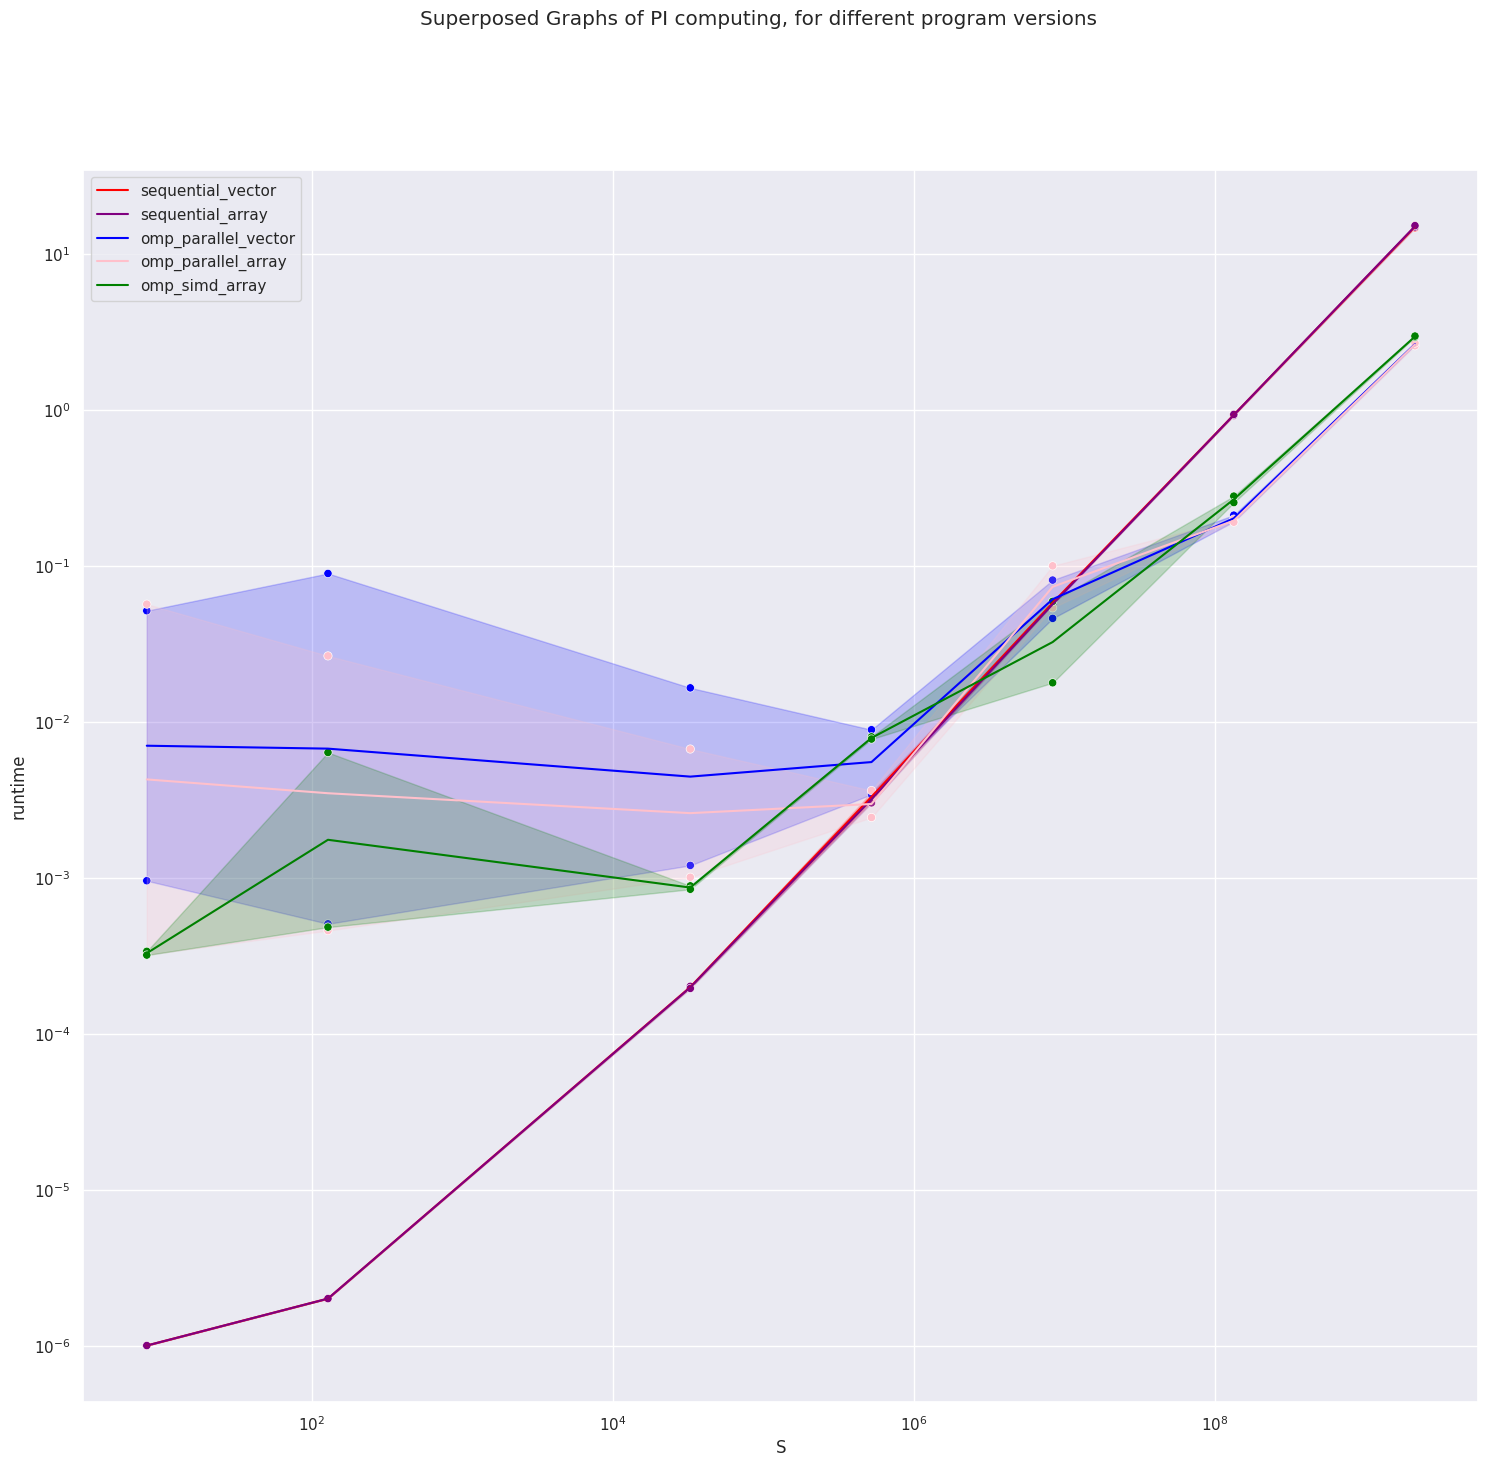

In [30]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import itertools
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# display graphs
fig, ax = plt.subplots(figsize=(18,16))
fig.suptitle("Superposed Graphs of custom matrix computing, for different program versions")

for i in range(0, len(color_class.keys())):
    # print version graph data
    graph_version = list(color_class.keys())[i]
    df_plot_0 = df[df['version'] == graph_version]

    g0 = sns.lineplot(
        ax=ax,
        data=df_plot_0, 
        x="S",
        y="runtime", 
        hue="version",
        palette=color_class,
        style="version",
    )
    g0.set(xscale="log")
    g0.set(yscale="log")
    g00 = sns.scatterplot(
        ax=ax,
        data=df_plot_0, 
        x="S",
        y="runtime", 
        hue="version",
        palette=color_class,
        legend=False,
    )
    g00.set(xscale="log")
    g00.set(yscale="log")


plt.legend()
plt.show()


#### Discussions

On observe que la variabilité des temps de calcul varie beaucoup pour les petites valeurs, mais très faiblement pour les grandes. C'est un résultat attendu.

On observe en pour les petites valeurs de S, c'est-à-dire pour un faible nombre de calculs, la version séquentielle est largement la plus rapide. Une inversion s'opère vers S ~= 10^6. À partir de ce niveau, les versions parallèles sont plus rapides. En particulier, la version SIMD Array est la plus rapide vers S ~= 10^7, et à partir de S ~= 10^8, les versions parallèles vector et array sont fortement similaires et sont les plus intéressantes, suivi de près par la version SIMD array. 

On peut tenter d'expliquer ces résultats en se disant que le compilateur `g++` produit déjà un code qui exploite la vectorisation, et ce faisant, qui limite grandement l'intérêt d'ajouter à la main des instructions pour la mettre en place.

Par rapport à la différence de performance entre l'utilisation des vectors face aux arrays de type C, la différence est seulement notable pour des petites valeurs de vecteurs, mais tend à converger avec l'augmentation de la taille des vecteurs.


Vector vs Array ?

```shell
(base) onyr@aezyr:~/Documents/code/OT5_open_mp_optimization/part_2$ ./bin/tp_openmp_part_2_vector_omp_parallel -nrepeat 10 -N 16 -M 15 -S 31
File: tp_openmp_part_2_vector_omp_parallel.cpp
  User N is 65536
  User M is 32768
  User S is 2147483648
  Total size S = 2147483648 N = 65536 M = 32768
  Computed result for 65536 x 32768 is 2147483648
  N( 65536 ) M( 32768 ) nrepeat ( 10 ) problem( 17180.7 MB ) time( 4.14559 s ) bandwidth( 41.4432 GB/s )
(base) onyr@aezyr:~/Documents/code/OT5_open_mp_optimization/part_2$ ./bin/tp_openmp_part_2_vector_omp_ -nrepeat 10 -N 16 -M 15 -S 31
tp_openmp_part_2_vector_omp_parallel              tp_openmp_part_2_vector_omp_simd_parallel_array   tp_openmp_part_2_vector_omp_simd_parallel_vector
(base) onyr@aezyr:~/Documents/code/OT5_open_mp_optimization/part_2$ ./bin/tp_openmp_part_2_vector_omp_simd_parallel_array -nrepeat 10 -N 16 -M 15 -S 31
File: tp_openmp_part_2_vector_omp_simd_parallel_array.cpp
  User N is 65536
  User M is 32768
  User S is 2147483648
  Total size S = 2147483648 N = 65536 M = 32768
  Computed result for 65536 x 32768 is 2147483648
  N( 65536 ) M( 32768 ) nrepeat ( 10 ) problem( 17180.7 MB ) time( 2.27771 s ) bandwidth( 75.4295 GB/s )
```

We have time(4.14559 s) with vector, time(2.27771 s) with `posix_memalign` C-array. We also tried with classical `malloc` but we have similar results as for with `posix_memalign`.

### Discussion